# W207 Group Project - What's Cooking?

Group members: Daniel Volk, Aaron Yuen

Kaggle competition link: https://www.kaggle.com/c/whats-cooking

## Business Understanding

#### Description from Kaggle:

Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

#### What problem are we trying to solve?

The problem at hand is to categorize the cuisine of a recipe based on the provided list of ingredients. This competition was hosted by Yummly, a company that builds a mobile app and website that provides recipe recommendations personalized to the individual's tastes. This is a multi-class classification problem where the input is a list of strings (ingredients) and the output we are trying to predict is one of the various classes of cuisine. 

#### What will we deliver?

The main deliverable is this iPython notebook that completes the full end-to-end project from problem scope, data understanding, exploratory analysis, baseline model, feature engineering, error analysis and final results.

## Data Understanding

#### Library Imports

In [441]:
# Loading all relevant libraries
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import seaborn as sn
sn.set()

matplotlib.rc('font', **{'weight' : 'bold', 'size':10} )

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score
from sklearn import svm
from sklearn.utils import resample
from xgboost import XGBClassifier
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#### Data Loading

The provided sources of data from the competition are:

1. train.json - Includes both the list of ingredients as features and the cuisine as the class
2. test.json - Includes only the list of ingredients as features. The cuisine (e.g. the class) is not present.


In [505]:
# Read train and test dataset from the provided JSONs
train = pd.read_json("data/train.json")
test = pd.read_json("data/test.json")

# Separate to raw features dataframe
X_train_all = train["ingredients"]
X_test = test["ingredients"]

# Separate label dataframe
y_train_all = train["cuisine"]

In [482]:
print "Shape of features:", X_train_all.shape
print "Shape of labels:", y_train_all.shape

Shape of features: (39774,)
Shape of labels: (39774,)


#### Example features and labels

In [42]:
print "First 10 example features from the training set"
print X_train_all.head(10)
print ""

print "First 10 example labels from the training set"
print y_train_all.head(10)
print ""

print "First 10 example features from the test set"
print X_test.head(10)
print ""

First 10 example features from the training set
0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
4    [black pepper, shallots, cornflour, cayenne pe...
5    [plain flour, sugar, butter, eggs, fresh ginge...
6    [olive oil, salt, medium shrimp, pepper, garli...
7    [sugar, pistachio nuts, white almond bark, flo...
8    [olive oil, purple onion, fresh pineapple, por...
9    [chopped tomatoes, fresh basil, garlic, extra-...
Name: ingredients, dtype: object

First 10 example labels from the training set
0          greek
1    southern_us
2       filipino
3         indian
4         indian
5       jamaican
6        spanish
7        italian
8        mexican
9        italian
Name: cuisine, dtype: object

First 10 example features from the test set
0    [baking powder, eggs, all-purpose flour, raisi...
1    [sugar, egg yolks,

In [483]:
# Check for nulls in the ingredients column
print "The number of examples where ingredients is null is", (X_train_all.isnull()).sum()

The number of examples where ingredients is null is 0


#### Distribution of training classes

Here we can see that there is a high imbalance of classes, with majority of the cuisine to be Italian, Mexican, and Southern US. We'll need to ensure in the data preparation step that these are more balanced before training, or make sure that if we don't handle it ourselves, the model already rebalances the classes based on label frequencies (e.g. like in LogisticRegression).

Text(0.5,0,u'Number of examples')

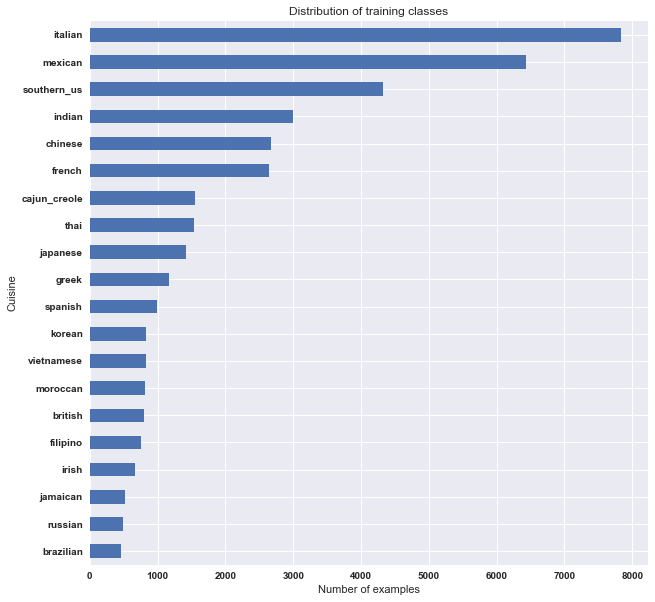

In [484]:
# Plot distribution of training classes
plt.figure(figsize=(10,10))
f = y_values = y_train_all.value_counts().plot(kind='barh')
f.invert_yaxis()
plt.title("Distribution of training classes")
plt.ylabel("Cuisine")
plt.xlabel("Number of examples")

#### Number of Ingredients per Recipe

Text(0.5,0,u'Ingredients per recipe')

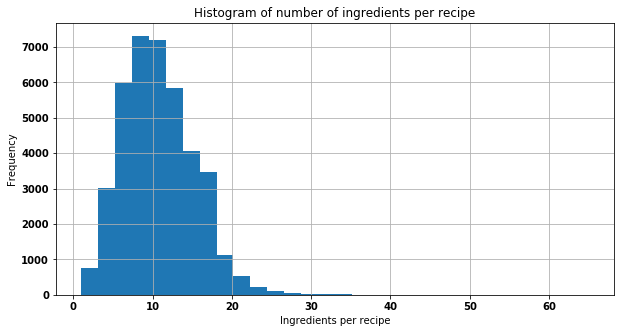

In [45]:
plt.figure(figsize=(10,5))
f = X_train_all.apply(len).hist(bins=30)
plt.title("Histogram of number of ingredients per recipe")
plt.ylabel("Frequency")
plt.xlabel("Ingredients per recipe")

#### Most Common Ingredients - Across All Cuisines

The top ingredients seem to be very common ingredients like salt, sugar, oil, etc. which may not be cusine-specific. These features could potentially be ruled out (or let the model feature-select). Here we can also see that there are similar ingredients that should be deduplicated (e.g. kosher salt and salt, olive oil and oil).

In [46]:
# For each row, go through each ingredient and create a cuisine-ingredient pair
ing_cuisine_pair = []
for i in xrange(X_train_all.shape[0]):
    for ingredient in X_train_all[i]:
        ing_cuisine_pair.append([y_train_all[i], ingredient])

ing_cuisine = pandas.DataFrame(ing_cuisine_pair, columns=['cuisine', 'ingredient'])

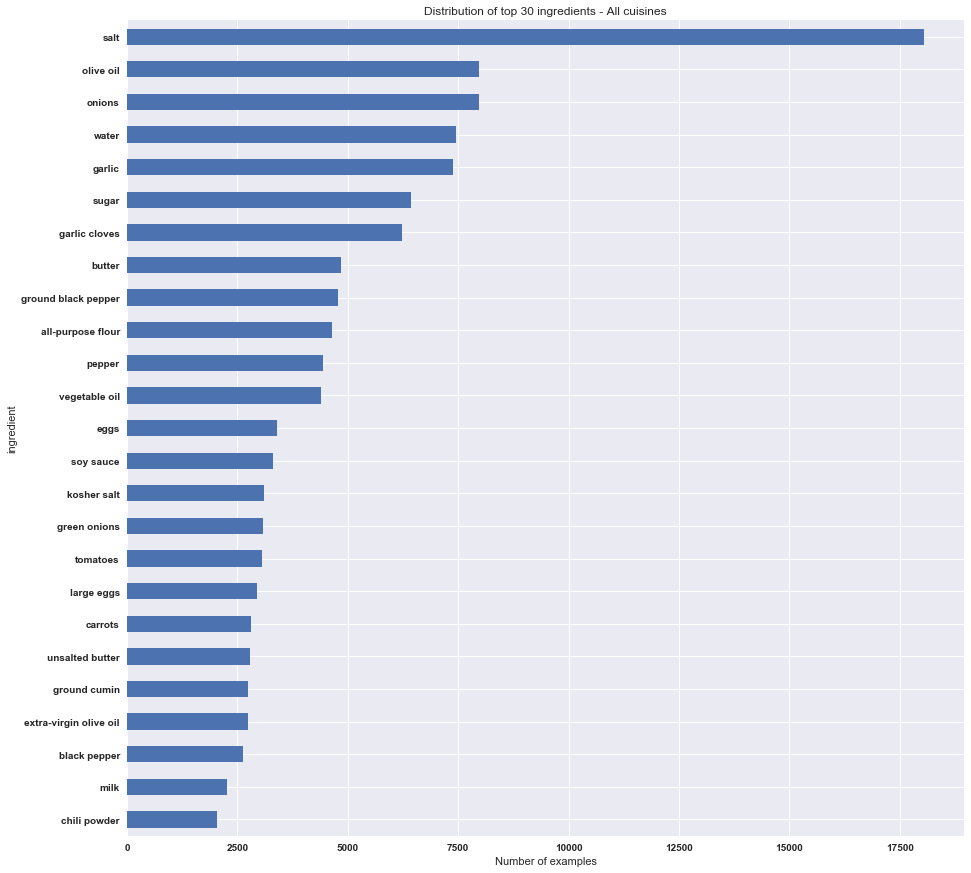

In [488]:
plt.figure(figsize=(15,15))
plt.title("Distribution of top 30 ingredients - All cuisines")
plt.ylabel("ingredient")
plt.xlabel("Number of examples")
f = ing_cuisine['ingredient'].value_counts()[:25].plot(kind='barh')
f.invert_yaxis()

#### Most Common Ingredients - By Cuisine

Similarly, here by cuisine the top ingredients are common ingredients like salt, but we start to see some cuisine-specific incredients like jalapeno chilies for Mexican and soy sauce for Chinese. Below are the top ingredients by four cuisines (out of the 20 cuisines).

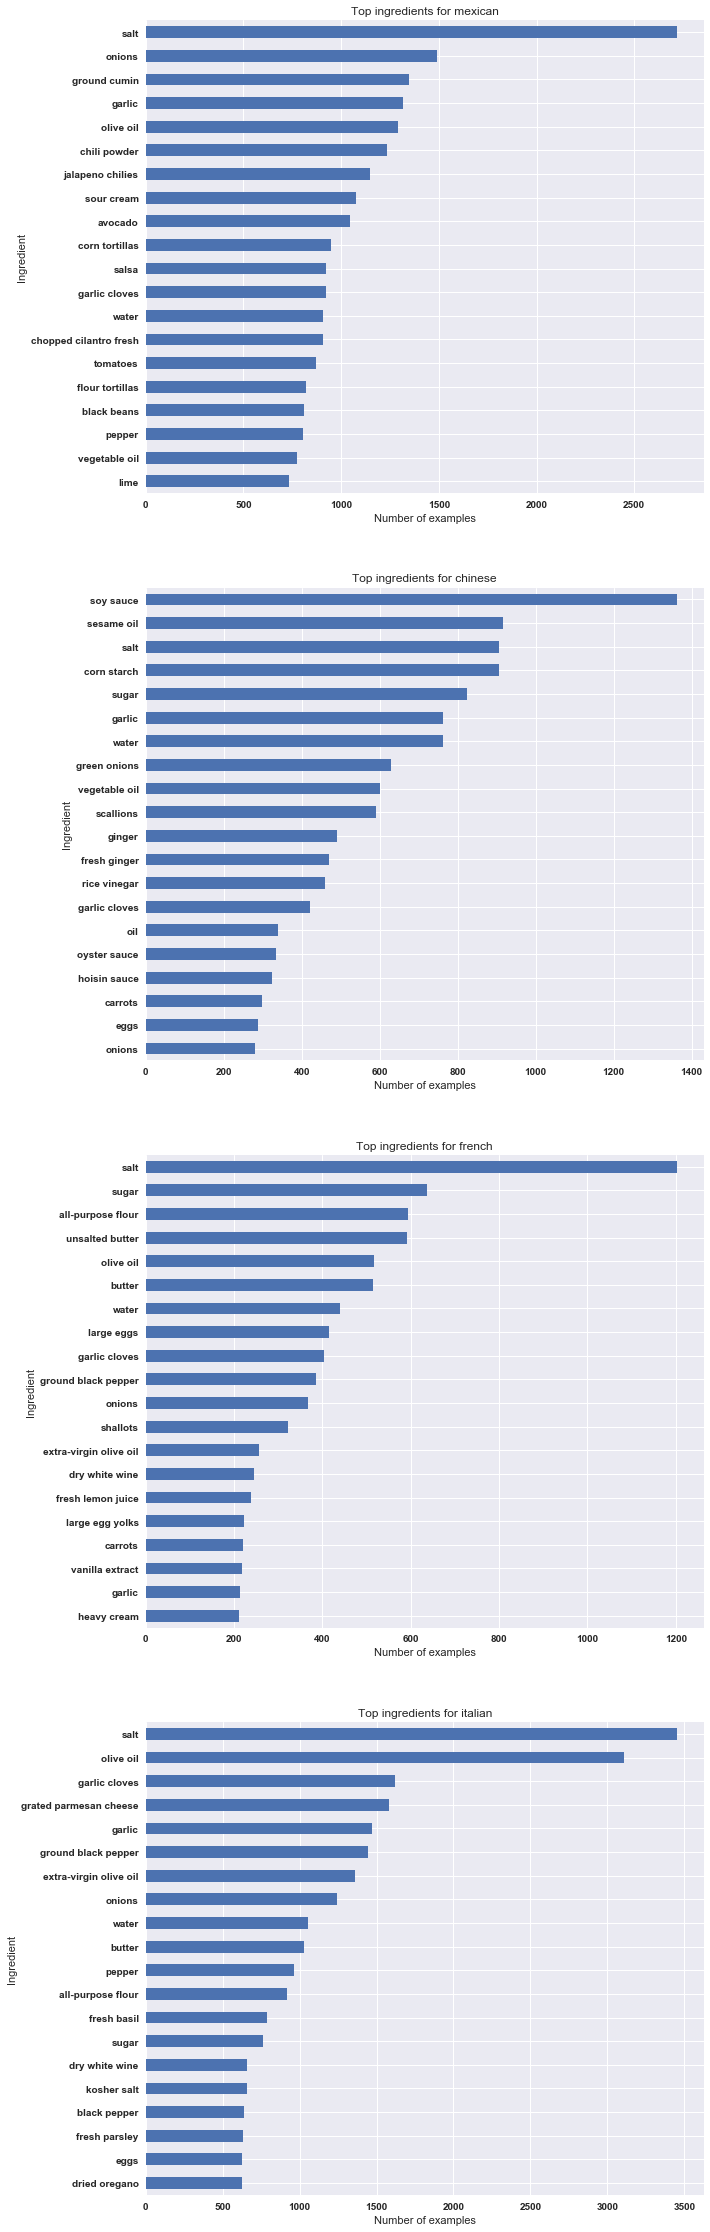

In [492]:
# Top ingredients by cuisine
plt.figure(figsize=(10,40))

grouped = ing_cuisine.groupby('cuisine')
cuisine_list = ['mexican', 'chinese', 'french', 'italian']

cuisines = grouped.groups.keys()
j = 0
for i in range(len(cuisines)):
    if cuisines[i] not in cuisine_list:
        continue

    plt.subplot(len(cuisine_list), 1, j+1)
    j+=1
    
    f = ing_cuisine[ing_cuisine['cuisine'] == cuisines[i]]['ingredient'].value_counts()[:20].plot(kind='barh')
    f.invert_yaxis()
    plt.title("Top ingredients for %s" % cuisines[i])
    plt.ylabel("Ingredient")
    plt.xlabel("Number of examples")
    i+=1

plt.show()

#### Least Common Ingredients - All Cuisines

There are also a long tail of uncommon ingredients in the data. Many of these tail ingredients seem to be just common ingredients (e.g. jack cheese) with additional modifiers (e.g. reduced fat). Below is an extreme case where the ingredient "one third less sodium chicken broth" really should just be chicken broth. One approach we want to look into is to find a systemmatic way of removing these modifies and normalizing them to the more common ingredients, which should reduce the total number of unique ingredients.

In [513]:
ing_cuisine['ingredient'].value_counts()[-25:]

Nakano Seasoned Rice Vinegar                             1
turkey breast steaks                                     1
Tuttorosso Diced Tomatoes                                1
nigari tofu                                              1
citrus vinaigrette                                       1
yam noodles                                              1
lambrusco                                                1
kingfish                                                 1
dried raspberry                                          1
poppyseeds                                               1
Crystal Farms Reduced Fat Shredded Marble Jack Cheese    1
chile piquin                                             1
fiddlehead ferns                                         1
jamaican jerk                                            1
butternut                                                1
chestnut spread                                          1
one third less sodium chicken broth                     

## Baseline Data Preparation

In [50]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_all, y_train_all, random_state=2)

In [51]:
print "The shape of X_train is", X_train.shape
print "The shape of X_dev is ", X_dev.shape
print "The shape of y_train is", y_train.shape
print "The shape of y_dev is", y_dev.shape

The shape of X_train is (29830,)
The shape of X_dev is  (9944,)
The shape of y_train is (29830,)
The shape of y_dev is (9944,)


In [52]:
def list_to_string(l):
    return '|'.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

## Baseline Model

#### Training

For the baseline model, we are starting with a very simple logistic regression model with no hyperparameter tuning. We will also be using a very basic count vectorizer. The goal of this is really to establish a baseline and understand what the metrics are for this very basic model. Note that no class balancing is done here for the baseline model. This will be explored in a subsequent section.

In [495]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer(binary=True)),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Evaluation - Accuracy

In [496]:
print "Accuracy of the base model is", base_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.776448109413


#### Confusion matrix
From the confusion matrix, it can be seen that the baseline model confuses French and Italian cuisines considerably. Southern and Cajun Creole are also confused by the model.

Text(0.5,1,u'Confusion matrix for the baseline model')

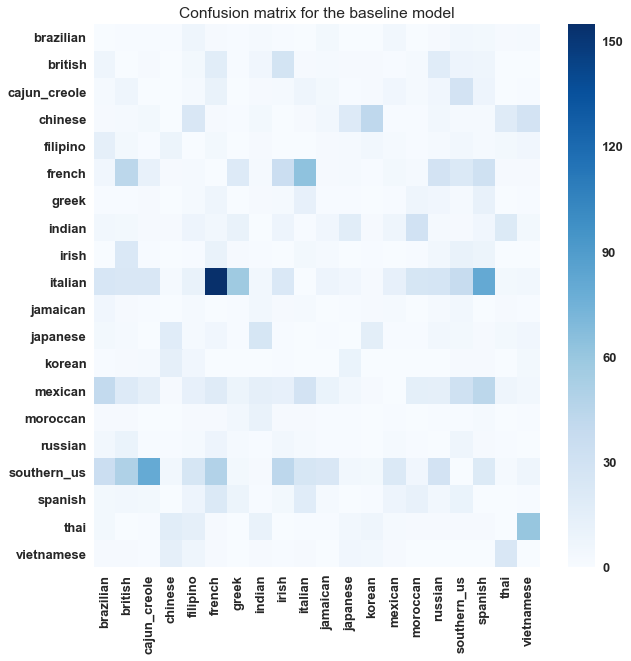

In [497]:
cm = confusion_matrix(y_dev, y_pred)
np.fill_diagonal(cm, 0)
cm_df = pandas.DataFrame(cm, index=base_pipeline.classes_, columns=base_pipeline.classes_)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.3)
ax = sn.heatmap(cm_df, cmap="Blues")
plt.title("Confusion matrix for the baseline model")

#### Error Analysis

In [503]:
pd.set_option('display.max_colwidth', -1)
train[['cuisine', 'ingredients']]

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"
5,jamaican,"[plain flour, sugar, butter, eggs, fresh ginger root, salt, ground cinnamon, milk, vanilla extract, ground ginger, powdered sugar, baking powder]"
6,spanish,"[olive oil, salt, medium shrimp, pepper, garlic, chopped cilantro, jalapeno chilies, flat leaf parsley, skirt steak, white vinegar, sea salt, bay leaf, chorizo sausage]"
7,italian,"[sugar, pistachio nuts, white almond bark, flour, vanilla extract, olive oil, almond extract, eggs, baking powder, dried cranberries]"
8,mexican,"[olive oil, purple onion, fresh pineapple, pork, poblano peppers, corn tortillas, cheddar cheese, ground black pepper, salt, iceberg lettuce, lime, jalapeno chilies, chopped cilantro fresh]"
9,italian,"[chopped tomatoes, fresh basil, garlic, extra-virgin olive oil, kosher salt, flat leaf parsley]"


## [SUGGEST WE REMOVE] Model with Balanced Training Classes

In [257]:
train_all = pd.DataFrame([X_train_str, y_train]).T
max_count = y_train.value_counts().max()
max_class = y_train.value_counts().idxmax()

resampled_train_all = train_all[train_all.cuisine == max_class]
for c in y_train.unique():
    if c == max_class:
        continue
        
    c_train_all = train_all[train_all.cuisine == c]
    c_train_all = resample(c_train_all, replace=True, n_samples=max_count, random_state=123)
    resampled_train_all = resampled_train_all.append(c_train_all)

resampled_train_all.cuisine.value_counts()

cajun_creole    5875
russian         5875
filipino        5875
french          5875
spanish         5875
brazilian       5875
jamaican        5875
mexican         5875
moroccan        5875
vietnamese      5875
indian          5875
korean          5875
italian         5875
irish           5875
southern_us     5875
greek           5875
british         5875
thai            5875
chinese         5875
japanese        5875
Name: cuisine, dtype: int64

In [260]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer(binary=True)),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(resampled_train_all.ingredients, resampled_train_all.cuisine)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [261]:
print "Accuracy of the base model is", base_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.740949316171


## Baseline Model with Broadmatch

#### Broadmatch Technique

To address the problem of normalizing the long, "uncommon" ingredients like "one third less sodium chicken broth" to just "chicken broth", we feel this will improve model performance, since if an ingredient in the test set has not been seen before from the training set, then that ingredient has no predictive power. That said, the ingredient may just have been a common ingredient with a unique modifier term.

Here we introduce a technique called "broadmatching" where we take each ingredient and recurisively drop terms to see if the resulting substring is a more common ingredient than the original ingredient. To assess what is more "common", we leverage the training set to look at how many recipes contain the ingredient. E.g. "salt" would have a high num_recipes where as "finely grounded sea salt" would have a low num_recipes.

In [548]:
# Helper function for normalizing strings
def normalize(s):
    lm = WordNetLemmatizer()
    printable = string.printable
    PERMITTED_CHARS = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ " 

    filter(lambda x: x in printable, s)
    s = "".join(c for c in s if c in PERMITTED_CHARS)
    s = lm.lemmatize(s.lower())

    return s 

# Build a list of ingredients across all recipes (used for counting later)
ingredient_list = []
i = 0
for ingredients in X_train_str:
    for ingredient in ingredients.split(' '):
        ingredient_list.append(normalize(ingredient.replace('_', ' ')))
        
# Flatten the list to an ingredient - count table, to be used for broadmatching
ing_counts = pd.DataFrame(ingredient_list, columns=['num_recipes']).num_recipes.value_counts()
ing_df = pd.DataFrame(ing_counts)
ing_df.index.names = ['ingredient']

# Given an ingredient, return all subsets of the ingredient string as a list of strings
def get_substrings(ingredient):
    # Base case - Return an empty list of the string is empty
    if ingredient == '':
        return []
    
    word_list = ingredient.split(' ')
    substring_list = []
    substring_list.append(ingredient)
    
    # Base case - Return a list with only the ingredient if there is only one word
    if len(word_list) == 1:
        return substring_list
    
    # Recursive Case    
    for i in range(len(word_list)):
        new_list = np.array(word_list, copy=True).tolist()
        new_list.remove(word_list[i])
        substring_word = ' '.join(new_list)
        substring_list.append(substring_word)
        
        sub_list = get_substrings(substring_word)
        for w in sub_list:
            substring_list.append(w)

    return substring_list

# Dedupes the output list of get_substrings function
def get_substrings_deduped(substring_list):
    return np.unique(get_substrings(substring_list)).tolist()

In [525]:
# Finding the broadmatched ingredient for each unique ingredient, storing in a dataframe as a look-up table
# Note: This code takes quite a bit of time to compute
norm_ing_arr = []
for i in range(len(ing_df.index)):
    norm_ing_arr.append([ing_df.index[i], broadmatch(ing_df.index[i])])
    
norm_ing_df = pd.DataFrame(norm_ing_arr, columns = ['Original Ingredient', 'Broadmatched Ingredient'])
norm_ing_df.head(10)

,Original Ingredient,Broadmatched Ingredient
0,salt,salt
1,onion,onion
2,olive oil,olive oil
3,water,water
4,garlic,garlic
5,sugar,sugar
6,garlic cloves,garlic
7,butter,butter
8,ground black pepper,ground black pepper
9,allpurpose flour,allpurpose flour


#### Broadmatch Analysis
Broadmatching seems to have greatly reduced the number of unique ingredients in the training data. This shows good signs that broadmatching was able to deduplicate tail ingredients to more common ingredient.

In [549]:
print "Number of unique ingredients before broadmatching %d" % norm_ing_df['Original Ingredient'].unique().shape
print "Number of unique ingredients after broadmatching %d" % norm_ing_df['Broadmatched Ingredient'].unique().shape

Number of unique ingredients before broadmatching 6224
Number of unique ingredients after broadmatching 2187


Below are a few examples where broad matching tends to do really well. In these cases, dropping terms led to finding a more common ingredient that would be more relevant for training purposes.

In [543]:
print "Good examples:"
print "frozen lemonade concentrate thawed and undiluted --> %s" % broadmatch("frozen lemonade concentrate thawed and undiluted")
print "tomato sauce low sodium --> %s" % broadmatch("tomato sauce low sodium")
print "johnsonville hot  spicy sausage slices --> %s" % broadmatch("johnsonville hot  spicy sausage slices")
print "new mexico red chile powder --> %s" % broadmatch("new mexico red chile powder")
print "raw peeled prawns --> %s" % broadmatch("raw peeled prawns")

Good examples:
frozen lemonade concentrate thawed and undiluted --> frozen lemonade concentrate
tomato sauce low sodium --> tomato
johnsonville hot  spicy sausage slices --> sausage
new mexico red chile powder --> chile


That said, there are also some examples where broadmatching does not tend to work well. In some cases, broadmatching was too aggressive, where the broadmatched ingredient was too common. In other cases, a relevant term gets dropped, in which case the actually ingredient changed after broadmatching. From inspection, it does look like broadmatching works well in more cases than not work well.

In [544]:
print "Bad examples:"
print "condensed cream of broccoli soup --> %s" % broadmatch("condensed cream of broccoli soup")
print "orange pekoe tea --> %s" % broadmatch("orange pekoe tea")
print "whole wheat pita pockets --> %s" % broadmatch("whole wheat pita pockets")
print "garlic herb spreadable cheese --> %s" % broadmatch("garlic herb spreadable cheese")
print "reduced sodium beef stock --> %s" % broadmatch("reduced sodium beef stock")

Bad examples:
condensed cream of broccoli soup --> cream
orange pekoe tea --> orange
whole wheat pita pockets --> pita
garlic herb spreadable cheese --> garlic
reduced sodium beef stock --> beef


#### Adding Broadmatch to the Baseline Model

In [527]:
# Convert the look-up table to a dictionary for the actual look-up
bm_dict = {}
for i, row in norm_ing_df.iterrows():
    bm_dict[row['Original Ingredient']] = row['Broadmatched Ingredient']

In [528]:
def broadmatch_string(s):
    final_ing_list = []
    for ing in s.split(' '):
        ing = ing.replace('_', ' ')
        if ing in bm_dict:
            ing = bm_dict[ing]
        final_ing_list.append(ing.replace(' ', '_'))
    
    return ' '.join(final_ing_list)

# Create a broadmatch function to be used for the pipeline
def broadmatch_X(X, turn_on):
    if turn_on == True:
        return X.apply(broadmatch_string)
    else:
        return X

In [529]:
broadmatch_pipeline = Pipeline(steps=[
    ('broaddmatch', FunctionTransformer(broadmatch_X, validate=False, kw_args={ "turn_on" : True })),
    ('countvectorizer', CountVectorizer(binary=True, min_df=10)),
    ('lr', LogisticRegression()),
])
broadmatch_pipeline.fit(resampled_train_all.ingredients, resampled_train_all.cuisine)

Pipeline(memory=None,
     steps=[('broaddmatch', FunctionTransformer(accept_sparse=False,
          func=<function broadmatch_X at 0x1a37d00aa0>, inv_kw_args=None,
          inverse_func=None, kw_args={'turn_on': True},
          pass_y='deprecated', validate=False)), ('countvectorizer', CountVectorizer(analyzer=u'word', bin...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [530]:
print "Accuracy of the base model is", broadmatch_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.702835880933


#### Confusion Matrix

Using broadmatching surprisingly led to a considerably lower accuracy. Looking at the confusion matrix, it is very similar to the confusion matrix for the baseline model. From additional analyses, we have found that broadmatching sometimes were too aggressive, and many ingredients broadmatched to very common ingredients, which further enhanced the problem of separating out cuisines based on only these common ingredients (e.g. salt, oil, etc.).

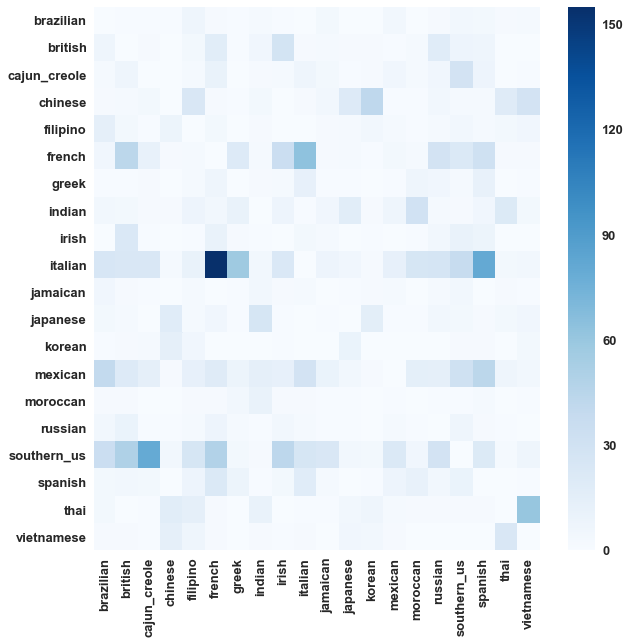

In [545]:
cm = confusion_matrix(y_dev, y_pred)
np.fill_diagonal(cm, 0)
cm_df = pandas.DataFrame(cm, index=broadmatch_pipeline.classes_, columns=broadmatch_pipeline.classes_)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.3)
ax = sn.heatmap(cm_df, cmap="Blues")

## [SUGGEST WE REMOVE] XGBoost Modeling with Hyper-Parameter Tuning

In [429]:
search_params = {
    #'broadmatch__kw_args': [{ "turn_on" : True }, { "turn_on" : False }],
    #'countvectorizer__min_df': np.linspace(5, 100, 5, dtype=int),
    #'countvectorizer__max_df': np.linspace(3000, 10000, 5, dtype=int),
    #'xg__max_depth' : np.linspace(10, 100, 5, dtype=int),
    #'xg__n_estimators' : np.linspace(50, 250, 5, dtype=int),
}


xgboost_pipeline = Pipeline(steps=[
    ('broadmatch', FunctionTransformer(broadmatch_X, validate=False, kw_args={ "turn_on" : False })),
    ('countvectorizer', CountVectorizer(binary=True, max_df = 8250, min_df=5)),
    ('xg', XGBClassifier(nthread=2, max_depth=77, n_estimators=250)),
])

xgboost_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('broadmatch', FunctionTransformer(accept_sparse=False,
          func=<function broadmatch_X at 0x1a37d001b8>, inv_kw_args=None,
          inverse_func=None, kw_args={'turn_on': False},
          pass_y='deprecated', validate=False)), ('countvectorizer', CountVectorizer(analyzer=u'word', bin...softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [430]:
print "Accuracy of the XGBoost model is", xgboost_pipeline.score(X_dev_str, y_dev)

Accuracy of the XGBoost model is 0.764782783588


## [SUGGEST WE REMOVE] Logistic Regression Modeling with Hyper-Parameter Tuning

In [433]:
search_params = {
    'broadmatch__kw_args': [{ "turn_on" : True }, { "turn_on" : False }],
    'lr__C' : [ 0.1, 1, 10, 100, 1000],
    'lr__multi_class' : ['ovr', 'multinomial'],
    'lr__solver' : ["newton-cg", "lbfgs", "sag", "saga"],
}


lr_pipeline = Pipeline(steps=[
    ('broadmatch', FunctionTransformer(broadmatch_X, validate=False)),
    ('countvectorizer', CountVectorizer(binary=True, max_df = 8250, min_df=5)),
    ('lr', LogisticRegression(n_jobs=2)),
])

grid_search_lr = GridSearchCV(lr_pipeline, search_params, cv=5, verbose=10)
grid_search_lr.fit(X_train_str, y_train)
grid_search_lr.best_params_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.710363301524, total=   4.4s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.72172893282, total=   4.0s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.0s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.714046262152, total=   4.4s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.728950016773, total=   4.2s
[CV] lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.4s remaining:    0.0s


[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.721308724832, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.1s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.710363301524, total=   3.1s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.0s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.72172893282, total=   3.1s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.9s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.714046262152, total=   3.0s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.7s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.728950016773, total=   3.1s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.7s remaining:    0.0s


[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.721308724832, total=   3.0s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.71053072158, total=  35.1s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.72172893282, total=  35.9s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.714213878646, total=  36.0s
[CV] lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=0.1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.728950016773, t

[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.743345052737, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.753727592562, total=   3.6s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.746396245391, total=   3.7s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.762831264676, total=   4.2s
[CV] lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.749832214765, t

[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.743675657564, total=   5.9s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.739188736172, total=   6.0s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.754444817175, total=   5.8s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.743791946309, total=   6.1s
[CV] lr__solver=lbfgs, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__mul

[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.738350653704, total=   5.1s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.755283461926, total=   5.0s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.740939597315, total=   5.0s
[CV] lr__solver=newton-cg, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr, score=0.726435626988, total=   8.7s
[CV] lr__solver=newton-cg, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=ovr 
[CV]  lr__solver=newton-cg, lr__C=100, broadmatch__kw_args

[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.737168735324, total=   4.6s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.728859060403, total=   4.8s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.729784028127, total=   5.0s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.728262690568, total=   5.0s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=saga, lr__C=100, broadmatch__k

[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.735826903724, total=   3.6s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.726342281879, total=   3.7s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.720743345053, total=   4.9s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial, score=0.715530239571, total=   4.8s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': True}, lr__multi_class=multinomial 
[CV]  lr__solver=sag, lr__C=1000, broa

[CV]  lr__solver=newton-cg, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.745469798658, total=   3.8s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.737652770802, total=   2.9s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.741330206065, total=   2.8s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.736004022796, total=   2.9s
[CV] lr__solver=lbfgs, lr__C=0.1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=lbfgs, 

[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.761593838942, total=   5.3s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.768302898308, total=   5.7s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.756620851492, total=   5.2s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial, score=0.775746393828, total=   5.4s
[CV] lr__solver=newton-cg, lr__C=1, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__so

[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.76193667281, total=  47.0s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.757123700972, total=  56.9s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.772727272727, total=  56.9s
[CV] lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.768120805369, total=  56.1s
[CV] lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=multinomial 
[CV]  lr__solver=newton-cg, lr__C=10, broadmatch__kw_args={'turn_on': False}, lr__multi_class=mu

[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.751047076562, total=  55.6s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.743211532015, total=  56.4s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.756457564576, total=  56.6s
[CV] lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.756543624161, total=  56.2s
[CV] lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=saga, lr__C=100, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.7565

[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.699112079075, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.704994971505, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.706642066421, total=   3.9s
[CV] lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=lbfgs, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr, score=0.710906040268, total=   4.0s
[CV] lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_class=ovr 
[CV]  lr__solver=sag, lr__C=1000, broadmatch__kw_args={'turn_on': False}, lr__multi_cl

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 124.9min finished


{'broadmatch__kw_args': {'turn_on': False},
 'lr__C': 1,
 'lr__multi_class': 'ovr',
 'lr__solver': 'saga'}

In [434]:
print "Accuracy of the Logistic Regression model is", grid_search_lr.score(X_dev_str, y_dev)

Accuracy of the Logistic Regression model is 0.773230088496


## Conclusion

MORE HERE

To take this challenge further, to accurately predict the correct cuisine, ideally we would love to have additional data along with the ingredients. 

As seen in our analysis, ingreidents alone may not have enough predictive signals to accurately predict a cuisine given that cuisines like French and Italian have highly overlapping ingredients. Additional data like instructions for cooking the recipe may help differentiate different cuisines. For example, cooking sous vide is very specific to French cooking, and boiling and simmering is more common with Italian cooking.

Through inspection, broadmatching seems to show good promise, although there were cases where broadmatching was too aggressive. We think that introducing some threshold on how much to broadmatch would prevent such agressively-broadmatched cases. 